In [12]:
#Final CODE PARALLEL
import numpy as np
from numpy.linalg import eigh
import time
import matplotlib.pyplot as plt
import math
import pyspark
from pyspark import SparkContext
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix
from scipy import stats


def create_block_matrix_from_numpy(
    np_array: np.ndarray,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Create a BlockMatrix from a NumPy array.
    
    Args:
        np_array (np.ndarray): NumPy array to be converted
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
        sc: SparkContext for parallelization
        
    Returns:
        BlockMatrix: Distributed block matrix representation of input array
    """
    num_rows: int = 0
    num_cols: int = 0
    blocks: list = []
    blocks_rdd: pyspark.RDD = None
    block_dense_matrix: Matrices.dense = None
    
    num_rows, num_cols = np_array.shape

    for j in range(0, num_cols, col_block_count):
        for i in range(0, num_rows, row_block_count):
            block = np_array[i:i + row_block_count, j:j + col_block_count]
            block_dense_matrix = Matrices.dense(block.shape[0], block.shape[1], block.T.flatten())
            blocks.append(((i // row_block_count, j // col_block_count), block_dense_matrix))

    blocks_rdd = sc.parallelize(blocks)
    
    return BlockMatrix(blocks_rdd, row_block_count, col_block_count)
    
def svd(
    gram_mat: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Perform Singular Value Decomposition (SVD) on a Gramian matrix.
    
    Args:
        gram_mat (BlockMatrix): The input Gramian matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    
    Returns:
        tuple[BlockMatrix, BlockMatrix, BlockMatrix]: The U, Sigma-inverse, and V^T matrices as BlockMatrices.
    """
    matrix_size: int = 0
    tol: float = 0.0
    arr: np.ndarray = None
    eigval_V: np.ndarray = None
    eigvecs: np.ndarray = None
    idx: np.ndarray = None
    eigvals_inv: np.ndarray = None
    block_s_inv: BlockMatrix = None
    block_v: BlockMatrix = None
    
    tol = 1e-15

    # Compute and sort eigenvalues and eigenvectors with a numpy Array.
    arr = gram_mat.toLocalMatrix().toArray()
    eigval_V, eigvecs = np.linalg.eigh(arr)
    idx = eigval_V.argsort()[::-1]
    eigval_V = eigval_V[idx]
    eigvecs = eigvecs[:, idx]

    # Invert eigenvalues (set small ones to zero) and form a diagonal matrix.
    eigvals_inv = np.array([1/val if val > tol else 0 for val in eigval_V])
    eigvals_inv = np.diag(eigvals_inv)
    
    # Convert results to block matrices for Spark and transpose the eigenvectors.
    block_s_inv = create_block_matrix_from_numpy(eigvals_inv, int(math.ceil(eigvals_inv.shape[0]/n_workers)), int(math.ceil(eigvals_inv.shape[1]/n_workers)), sc)

    block_v = create_block_matrix_from_numpy(eigvecs, int(math.ceil(eigvecs.shape[0]/n_workers)), int(math.ceil(eigvecs.shape[1]/n_workers)), sc)
    
    return block_v.multiply(block_s_inv).multiply(block_v.transpose())

def betacalc(
    X: pyspark.mllib.linalg.distributed.BlockMatrix,
    Y: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Calculate the beta values for the input matrices X and Y.
    
    Args:
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    
    Returns:
        np.ndarray: The computed beta values.
    """
    XtX: BlockMatrix = None
    XtX_inv: BlockMatrix = None
    beta: BlockMatrix = None

    # Compute gram-matrix
    XtX = X.transpose().multiply(X)

    # Invert XtX using SVD.
    XtX_inv = svd(XtX, row_block_count, col_block_count, sc)

    # Compute and return betas
    beta = XtX_inv.multiply(X.transpose()).multiply(Y)
    return beta

def stat_values(
    X: pyspark.mllib.linalg.distributed.BlockMatrix,
    Y: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
):
    """
    Compute comprehensive linear model statistics
    Returns formatted string output
    
    Args:  
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    Returns:
        str: Formatted string containing OLS statistics
    """
    
    # Calculate beta and convert to local
    
    beta = betacalc(X, Y, row_block_count, col_block_count, sc)
    fitted_values = X.multiply(beta)
    residuals = Y.subtract(fitted_values)
    
    fitted_local = fitted_values.toLocalMatrix().toArray()
    residuals_local = residuals.toLocalMatrix().toArray()
    beta_local = beta.toLocalMatrix().toArray()

    # Get local matrices for calculations
    X_local = X.toLocalMatrix().toArray()
    Y_local = Y.toLocalMatrix().toArray()
    
    # Basic dimensions
    n = X.numRows()
    p = X.numCols()
    degrees_of_freedom = n - p
    
    # Residual statistics
    rss = np.sum(residuals_local ** 2)  # Residual sum of squares
    mse = rss / degrees_of_freedom
    rmse = np.sqrt(mse)
    
    # Calculate XtX and its inverse for standard errors
    XtX = X.transpose().multiply(X)
    XtX_local = XtX.toLocalMatrix().toArray()
    XtX_inv = np.linalg.inv(XtX_local)
    
    # Standard errors and t-values
    beta_std_errors = np.sqrt(np.diag(XtX_inv) * mse)
    t_values = beta_local.flatten() / beta_std_errors
    
    # Calculate p-values for t-statistics
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), degrees_of_freedom))
    
    # R-squared statistics
    y_mean = np.mean(Y_local)
    tss = np.sum((Y_local - y_mean) ** 2)  # Total sum of squares
    r_squared = 1 - (rss / tss)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / degrees_of_freedom)
    
    # F-statistic
    model_ss = tss - rss
    f_statistic = (model_ss / (p - 1)) / mse
    f_p_value = 1 - stats.f.cdf(f_statistic, p-1, degrees_of_freedom)
    
    # Residual analysis
    residuals_std = residuals_local / np.sqrt(mse)
    
    # Format output string similar to R's lm()
    output = []
    output.append("Call:")
    output.append("Linear Model Fit\n")
    
    output.append("Residuals:")
    residual_stats = {
        "Min": np.min(residuals_local),
        "1Q": np.percentile(residuals_local, 25),
        "Median": np.median(residuals_local),
        "3Q": np.percentile(residuals_local, 75),
        "Max": np.max(residuals_local)
    }
    output.append("".join(f"{k:>8}" for k in residual_stats.keys()))
    output.append("".join(f"{v:8.4f}" for v in residual_stats.values()))
    output.append("")
    
    # Coefficients table
    output.append("Coefficients:")
    output.append("              Estimate Std. Error t value Pr(>|t|)")
    for i in range(len(beta_local)):
        coef_line = f"Variable{i:2d} {beta_local[i][0]:9.4f} {beta_std_errors[i]:10.4f} {t_values[i]:7.3f} {p_values[i]:8.4f} "
        # Add significance stars like R
        if p_values[i] < 0.001:
            coef_line += "***"
        elif p_values[i] < 0.01:
            coef_line += "** "
        elif p_values[i] < 0.05:
            coef_line += "*  "
        elif p_values[i] < 0.1:
            coef_line += ".  "
        output.append(coef_line)
    output.append("---")
    output.append("Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1\n")
    
    # Model statistics
    output.append(f"Residual standard error: {np.sqrt(mse):.4f} on {degrees_of_freedom} degrees of freedom")
    output.append(f"Multiple R-squared: {r_squared:.4f}, Adjusted R-squared: {adj_r_squared:.4f}")
    output.append(f"F-statistic: {f_statistic:.2f} on {p-1} and {degrees_of_freedom} DF, p-value: {f_p_value:.4e}\n")
    
    # Additional diagnostic information
    output.append("Additional Statistics:")
    output.append(f"AIC: {n * np.log(rss/n) + 2*p:.4f}")
    output.append(f"BIC: {n * np.log(rss/n) + np.log(n)*p:.4f}")
    output.append(f"RMSE: {rmse:.4f}")
    
    return "\n".join(output)


def calculate_statistics(
    X: pyspark.mllib.linalg.distributed.BlockMatrix,
    Y: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
):
    """
    Compute comprehensive linear model statistics with statsmodels-style output
    
    Args:  
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
        sc: Spark context
    Returns:
        float: elapsed_time for calculating betas
        str: Formatted string containing OLS statistics in statsmodels style
    """
    
    # Calculate beta and convert to local
    elapsed_time = 0
    start_time = time.time()
    beta = betacalc(X, Y, row_block_count, col_block_count, sc)
    fitted_values = X.multiply(beta)
    residuals = Y.subtract(fitted_values)
    elapsed_time = elapsed_time + (time.time() - start_time)
    
    # Convert to local arrays for calculations
    fitted_local = fitted_values.toLocalMatrix().toArray()
    residuals_local = residuals.toLocalMatrix().toArray()
    beta_local = beta.toLocalMatrix().toArray()
    X_local = X.toLocalMatrix().toArray()
    Y_local = Y.toLocalMatrix().toArray()
    
    # Basic dimensions
    n = X.numRows()
    k = X.numCols()  
    df_model = k 
    df_resid = n - k
    
    # Residual statistics
    ssr = np.sum(residuals_local ** 2) 
    mse = ssr / df_resid
    
    # Calculate XtX and its inverse for standard errors
    XtX = X.transpose().multiply(X)
    XtX_local = XtX.toLocalMatrix().toArray()
    XtX_inv = np.linalg.inv(XtX_local)
    
    # Standard errors and t-values
    bse = np.sqrt(np.diag(XtX_inv) * mse)
    tvalues = beta_local.flatten() / bse
    pvalues = 2 * (1 - stats.t.cdf(np.abs(tvalues), df_resid))
    
    # Uncentered R-squared statistics
    tss_uncentered = np.sum(Y_local ** 2) 
    r2_uncentered = 1 - (ssr / tss_uncentered)
    adj_r2_uncentered = 1 - (1 - r2_uncentered) * (n / df_resid)
    
    # F-test (uncentered)
    ess = tss_uncentered - ssr  
    fvalue = (ess / df_model) / mse
    fpvalue = stats.f.sf(fvalue, df_model, df_resid)
    
    # Log-likelihood and information criteria
    llf = -n/2 * (1 + np.log(2*np.pi) + np.log(ssr/n))
    aic = -2 * llf + 2 * k
    bic = -2 * llf + np.log(n) * k
    
    # Additional diagnostics
    condition_number = np.sqrt(np.max(np.linalg.eigvals(XtX_local)) / 
                             np.min(np.linalg.eigvals(XtX_local)))
    
    # Residual diagnostics with corrected Jarque-Bera test
    residuals_standardized = residuals_local.flatten() / np.sqrt(mse)
    skew = stats.skew(residuals_standardized)
    kurtosis = stats.kurtosis(residuals_standardized, fisher=True)
    
    # Corrected Jarque-Bera calculation
    jb = n/6 * (skew**2 + (kurtosis**2)/4)
    jbpv = stats.chi2.sf(jb, df=2)  # Chi-square with 2 df
    
    # Omnibus test (D'Agostino K^2)
    k2, p_omnibus = stats.normaltest(residuals_standardized)
    
    # Durbin-Watson
    dw = np.sum(np.diff(residuals_local.flatten()) ** 2) / ssr
    
    # Create summary string similar to statsmodels
    summary = []
    summary.append("                            OLS Regression Results                            ")
    summary.append("===========================================================================")
    summary.append(f"Dep. Variable:                      y   R-squared (uncentered):     {r2_uncentered:>7.3f}")
    summary.append(f"Model:                            OLS   Adj. R-squared (uncentered):{adj_r2_uncentered:>7.3f}")
    summary.append(f"Method:                 Least Squares   F-statistic:                {fvalue:>7.3f}")
    summary.append(f"Date:                             now   Prob (F-statistic):         {fpvalue:>7.3f}")
    summary.append(f"Time:                             now   Log-Likelihood:             {llf:>7.3f}")
    summary.append(f"No. Observations:          {n:>10.0f}   AIC:                        {aic:>7.3f}")
    summary.append(f"Df Residuals:              {df_resid:>10.0f}   BIC:                        {bic:>7.3f}")
    summary.append(f"Df Model:                  {df_model:>10.0f}")
    summary.append("===========================================================================")
    summary.append("                coef    std err          t      P>|t|     [0.025     0.975]")
    summary.append("---------------------------------------------------------------------------")
    
    # Parameter estimates with confidence intervals
    conf_int = np.column_stack((
        beta_local.flatten() - stats.t.ppf(0.975, df_resid) * bse,
        beta_local.flatten() + stats.t.ppf(0.975, df_resid) * bse
    ))
    
    for i in range(k):
        summary.append(f"x{i:<8.0f} {beta_local[i][0]:>10.3f} {bse[i]:>10.3f} {tvalues[i]:>10.3f} {pvalues[i]:>10.3f} {conf_int[i,0]:>10.3f} {conf_int[i,1]:>10.3f}")
    
    summary.append("===========================================================================")
    summary.append(f"Omnibus:                   {k2:>10.3f}   Durbin-Watson:           {dw:>10.3f}")
    summary.append(f"Prob(Omnibus):             {p_omnibus:>10.3f}   Jarque-Bera (JB):        {jb:>10.3f}")
    summary.append(f"Skew:                      {skew:>10.3f}   Prob(JB):                {jbpv:>10.3f}")
    summary.append(f"Kurtosis:                  {kurtosis+3:>10.3f}   Cond. No.                {condition_number:>10.3f}")
    summary.append("===========================================================================")
    
    return elapsed_time, "\n".join(summary)

def run_performance_tests(
    n_features_list: list,
    n_rows: int,
    n_times: int,
    n_workers: int,
    sc):
    """
    Run performance tests and optionally visualize results
    
    Args:
        n_features_list (list): List of feature sizes to test
        n_rows (int): Number of rows in the matrices
        n_times (int): Number of test iterations per feature size
        n_workers (int): Number of Spark workers
        sc: Spark context
        
    Returns:
        tuple: Lists of elapsed_times, avg_elapsed_times, times_per_feature
    """
    elapsed_times = []
    avg_elapsed_times = []
    times_per_feature = []
    
    # Run performance tests
    for n_features in n_features_list:
        row_block_count = math.ceil(n_rows/n_workers)
        col_block_count = math.ceil(n_features/n_workers)
        matX, matY = create_random_block_matrix_and_vector(
            n_rows, n_features, row_block_count, col_block_count, sc
        )
        elapsed_time = 0
        
        for a in range(n_times):
            elapsed_time, stat = calculate_statistics(
                matX, matY, row_block_count, col_block_count, sc
            )
            print(stat)
            
        avg_elapsed_time = elapsed_time / n_times
        time_per_feature = avg_elapsed_time / n_features
        
        elapsed_times.append(elapsed_time)
        avg_elapsed_times.append(avg_elapsed_time)
        times_per_feature.append(time_per_feature)
        
        print(f"Features: {n_features}, Gesamtzeit: {elapsed_time:.5f} Sekunden")
        print(f"Features: {n_features}, durchschnittliche Zeit: {avg_elapsed_time:.5f} Sekunden")
        print(f"Features: {n_features}, durchschnittliche Zeit pro feature: {time_per_feature:.5f} Sekunden")
    
    # Visualization
    # Plot 1: Average Time
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    line2 = ax2.plot(n_features_list, avg_elapsed_times, 'r-', marker='s', 
                    label='Durchschnittliche Zeit')
    ax2.set_xlabel('Anzahl der Features')
    ax2.set_ylabel('Durchschnittliche Zeit (Sekunden)', color='r')
    plt.title('Laufzeitanalyse: Durchschnittliche Zeit', fontsize=16)
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    for x, y in zip(n_features_list, avg_elapsed_times):
        ax2.annotate(f'{y:.2f}s', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', color='r')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Time per Feature
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    line3 = ax3.plot(n_features_list, times_per_feature, 'g-', marker='s', 
                    label='Zeit pro Feature')
    ax3.set_xlabel('Anzahl der Features')
    ax3.set_ylabel('Zeit pro Feature (Sekunden)', color='g')
    plt.title('Laufzeitanalyse: Zeit pro Feature', fontsize=16)
    ax3.legend(loc='upper right')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    for x, y in zip(n_features_list, times_per_feature):
        ax3.annotate(f'{y:.3f}s', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', color='g')
    
    plt.tight_layout()
    plt.show()
    
    return elapsed_times, avg_elapsed_times, times_per_feature

def create_random_block_matrix_and_vector(n_rows: int, n_cols: int, row_block_count: int, col_block_count: int, sc):
    """
    Create random BlockMatrices for testing linear regression.
    
    Args:
        n_rows (int): Number of rows in the feature matrix
        n_cols (int): Number of columns in the feature matrix
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
        sc: SparkContext for parallelization
        
    Returns:
        tuple[BlockMatrix, BlockMatrix]: Random feature matrix X and target vector Y as BlockMatrices,
        where X is of shape (n_rows, n_cols) and Y is of shape (n_rows, 1)
    """
    np.random.seed(42)
    X = np.random.rand(n_rows, n_cols)
    Y = np.random.rand(n_rows, 1)

    X_block_matrix = create_block_matrix_from_numpy(X, row_block_count, col_block_count, sc)
    Y_block_matrix = create_block_matrix_from_numpy(Y, row_block_count, 1, sc)
    
    return X_block_matrix, Y_block_matrix

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.703
Model:                            OLS   Adj. R-squared (uncentered):  0.698
Method:                 Least Squares   F-statistic:                139.658
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             -73.710
No. Observations:                 300   AIC:                        157.420
Df Residuals:                     295   BIC:                        175.939
Df Model:                           5
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.339      0.055      6.182      0.000      0.231      0.447
x1             0.195      0.056      3.475      0.001      0.084      0.305
x2             0.219      0.056      3.870     

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.732
Model:                            OLS   Adj. R-squared (uncentered):  0.724
Method:                 Least Squares   F-statistic:                 99.529
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             -61.291
No. Observations:                 300   AIC:                        138.583
Df Residuals:                     292   BIC:                        168.213
Df Model:                           8
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.187      0.057      3.281      0.001      0.075      0.300
x1             0.248      0.055      4.503      0.000      0.140      0.357
x2             0.084      0.059      1.434     

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.734
Model:                            OLS   Adj. R-squared (uncentered):  0.724
Method:                 Least Squares   F-statistic:                 79.882
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             -51.391
No. Observations:                 300   AIC:                        122.782
Df Residuals:                     290   BIC:                        159.820
Df Model:                          10
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0            -0.034      0.055     -0.626      0.531     -0.143      0.074
x1             0.146      0.054      2.723      0.007      0.040      0.251
x2             0.127      0.057      2.221     

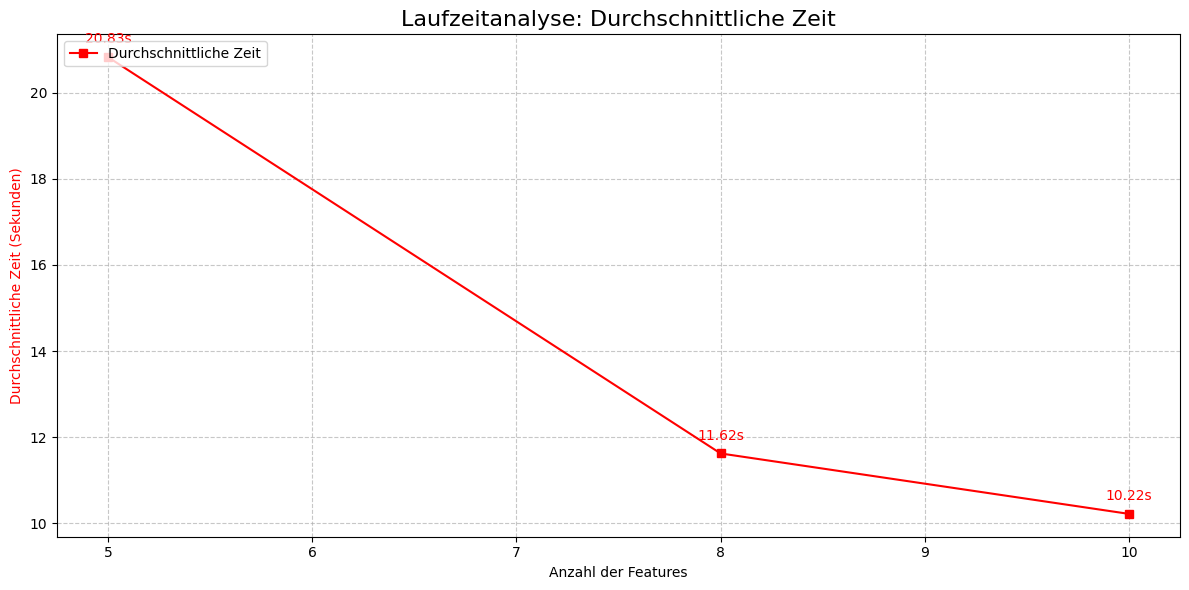

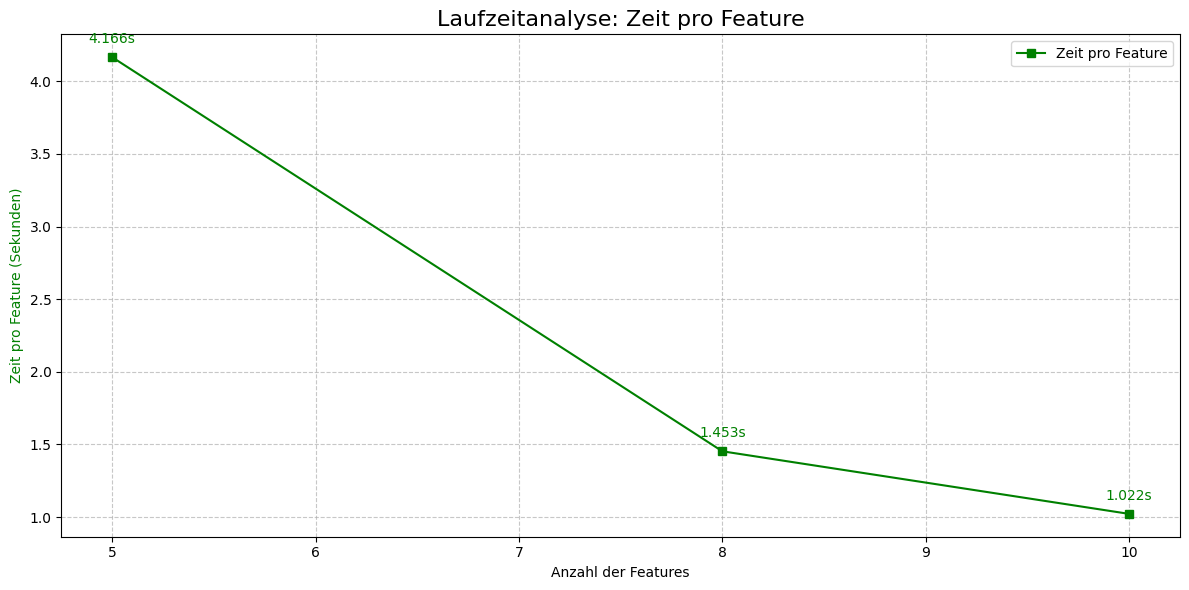

In [15]:
from pyspark.sql import SparkSession

#Hyperparameter
n_features_list = [5, 8, 10]
n_rows = max(n_features_list) * 30
n_times = 1
n_workers = 4
spark.stop()
    # Create Sparksession
spark = SparkSession.builder \
    .appName("Cluster-Based SVD Regression") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.default.parallelism", n_workers) \
    .config("spark.sql.shuffle.partitions", n_workers) \
    .getOrCreate()

sc = spark.sparkContext

# run Performance Test
elapsed_times, avg_times, times_per_feature = run_performance_tests(
    n_features_list=n_features_list,
    n_rows=n_rows,
    n_times=n_times,
    n_workers=n_workers,
    sc=sc,
)